In [1]:
import os 
import shutil 
import matplotlib.pyplot as plt 
import torchvision
import torch
import numpy as np
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import glob 

from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from skimage import io
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, ReLU, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from torchsummary import summary

In [2]:
root_path = r'E:\MATKUL\SKRIPSI\PROGRAM\model\dataset'
source_path = os.path.join(root_path,'dataset mentah') #tempat dataset disimpan
destination_path = os.path.join(root_path, 'dataset resnet34')
class_remp = ['jahe', 'kencur', 'ketumbar', 'kunyit', 'lengkuas', 'merica']

In [3]:
#melihat banyak data gambar dlm folder
folders = {}

for folder in os.listdir(source_path):
    folders[folder] = len(os.listdir(os.path.join(source_path,  folder)))

folders

{'jahe': 300,
 'kencur': 300,
 'ketumbar': 300,
 'kunyit': 300,
 'lengkuas': 300,
 'merica': 300}

In [4]:
if os.path.isdir(os.path.join(destination_path, 'training')):
    print(f"path {os.path.join(destination_path, 'training')} sudah ada")
else:
    os.makedirs(os.path.join(destination_path, 'training'))
    for folder in folders.keys():
        os.makedirs(os.path.join(destination_path, f'training/{folder}'))

if os.path.isdir(os.path.join(destination_path, 'testing')):
    print(f"path {os.path.join(destination_path, 'testing')} sudah ada")
else:
    os.makedirs(os.path.join(destination_path, 'testing'))
    for folder in folders.keys():
        os.makedirs(os.path.join(destination_path, f'testing/{folder}'))

In [5]:
remp_path = os.path.join(source_path,class_remp[2],'*')
remp_path = glob.glob(remp_path)

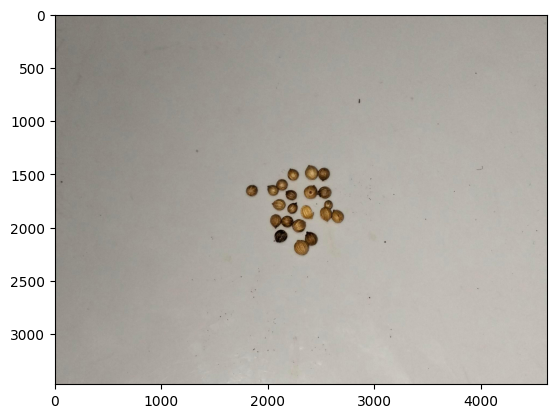

In [6]:
#Menampilkan gambar dari dataset
image = io.imread(remp_path[2])  

#memplot gambar original
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

In [7]:
files_name = {
    'jahe': [],    
    'kencur': [],
    'ketumbar': [],    
    'kunyit': [],
    'lengkuas': [],
    'merica': [],    
}

files_train = {
    'jahe': [],    
    'kencur': [],
    'ketumbar': [],    
    'kunyit': [],
    'lengkuas': [],
    'merica': [],    
}

files_test = {
    'jahe': [],    
    'kencur': [],
    'ketumbar': [],    
    'kunyit': [],
    'lengkuas': [],
    'merica': [],    
}

In [8]:
for type in files_name.keys():
    for file in os.listdir(os.path.join(source_path, type)):
        if os.path.getsize(os.path.join(source_path, f'{type}/{file}')):
            files_name[type].append(file)
        else:
            print(f'{file} dilewatkan')

In [9]:
len(files_name['kencur'][0])

13

In [10]:
split_data = {
    'jahe': 0,    
    'kencur': 0,
    'ketumbar': 0,    
    'kunyit': 0,
    'lengkuas': 0,
    'merica': 0,    
}

for key in split_data.keys():
    split_data[key] = int(len(files_name[key])*.8)

for key in files_train.keys():
    files_train[key].append(files_name[key][:split_data[key]])
    files_test[key].append(files_name[key][split_data[key]:])

In [11]:
len(files_train['kencur'][0])

240

In [12]:
len(files_test['kencur'][0])

60

In [13]:
source_path

'E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset mentah'

In [14]:
destination_path

'E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset resnet34'

In [15]:
for type in files_name.keys():
    for file in files_train[type][0]:
        shutil.copyfile(
            os.path.join(source_path, f'{type}/{file}'),
            os.path.join(destination_path, f'training/{type}/{file}')
        )
    for file in files_test[type][0]:
        shutil.copyfile(
            os.path.join(source_path, f'{type}/{file}'),
            os.path.join(destination_path, f'testing/{type}/{file}')
        )

In [3]:
# Augmentasi data
dataset_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),    
    transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(40),    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder('E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset resnet34\\training', transform=dataset_transforms)
test_dataset = torchvision.datasets.ImageFolder('E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset resnet34\\testing', transform=dataset_transforms)

train_load = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_load = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


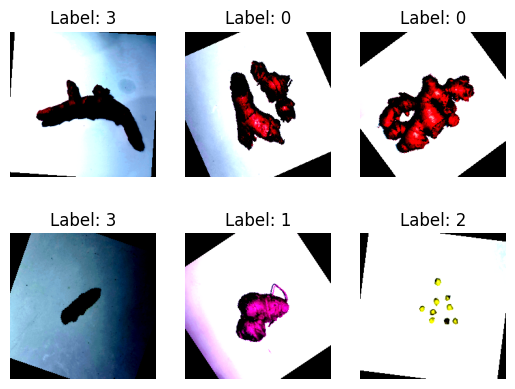

In [18]:
# Ambil batch gambar dari DataLoader
data_iter = iter(train_load)
images, labels = next(data_iter)

# Konversi tensor PyTorch ke array numpy
images = images.numpy()

# Ubah dimensi dari (batch_size, channels, height, width) menjadi (batch_size, height, width, channels)
images = np.transpose(images, (0, 2, 3, 1))

# Misalnya, tampilkan 6 gambar pertama dari batch
num_images_to_show = 6

for i in range(num_images_to_show):
    plt.subplot(2, 3, i + 1)  # Ubah angka 2, 3 sesuai dengan jumlah baris dan kolom yang Anda inginkan
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')

plt.show()

In [5]:
from torchvision import models

class CNNResNet34(nn.Module):
    def __init__(self, num_classes):
        super(CNNResNet34, self).__init__()
        self.resnet34 = models.resnet34(pretrained=True)
        self.resnet34.fc = nn.Linear(512, num_classes)  # Ganti output layer untuk sesuai dengan jumlah kelas

    def forward(self, x):
        return self.resnet34(x)

num_classes = len(class_remp)
model = CNNResNet34(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(3, 224, 224))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\nanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

CNNResNet34(
  (resnet34): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [20]:
# Fungsi untuk pelatihan
def train(model, train_load, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_load:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return running_loss / len(train_load), accuracy

# Fungsi untuk validasi
def validate(model, test_load, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_load:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return running_loss / len(test_load), accuracy

# Pelatihan model dengan 10 epochs
num_epochs = 20

# Inisialisasi list untuk menyimpan data
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Definisi LR scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.1, verbose=True)

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_load, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_load, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Menyimpan data
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Scheduler untuk mengatur learning rate berdasarkan performa data validasi
    scheduler.step(val_accuracy)

# Simpan model
torch.save(model.state_dict(), './finished model/resnet34.pth')

C:\Users\nanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20 - Train Loss: 0.8284, Train Accuracy: 0.6736 - Val Loss: 1.3115, Val Accuracy: 0.5306
Epoch 2/20 - Train Loss: 0.3517, Train Accuracy: 0.8757 - Val Loss: 3.3500, Val Accuracy: 0.5722
Epoch 3/20 - Train Loss: 0.3373, Train Accuracy: 0.8847 - Val Loss: 2.8778, Val Accuracy: 0.4417
Epoch 4/20 - Train Loss: 0.2467, Train Accuracy: 0.9146 - Val Loss: 1.1914, Val Accuracy: 0.6417
Epoch 5/20 - Train Loss: 0.2886, Train Accuracy: 0.9069 - Val Loss: 2.4321, Val Accuracy: 0.5556
Epoch 6/20 - Train Loss: 0.2347, Train Accuracy: 0.9194 - Val Loss: 0.6182, Val Accuracy: 0.8083
Epoch 7/20 - Train Loss: 0.1727, Train Accuracy: 0.9403 - Val Loss: 1.3074, Val Accuracy: 0.6472
Epoch 8/20 - Train Loss: 0.1332, Train Accuracy: 0.9597 - Val Loss: 0.7500, Val Accuracy: 0.7417
Epoch 9/20 - Train Loss: 0.1140, Train Accuracy: 0.9590 - Val Loss: 0.6199, Val Accuracy: 0.8389
Epoch 10/20 - Train Loss: 0.0987, Train Accuracy: 0.9708 - Val Loss: 0.6125, Val Accuracy: 0.8111
Epoch 11/20 - Train Loss: 0.1

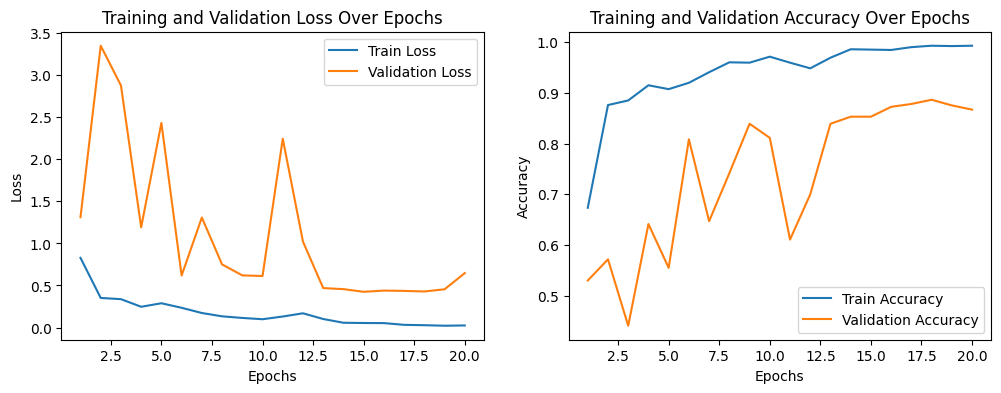

In [22]:
# Membuat plot
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Menyimpan plot ke file gambar
plt.savefig('plot_resnet34.png')

# Menampilkan plot
plt.show()

Akurasi: 87.22% || Presisi: 89.46% || Recall: 87.22%


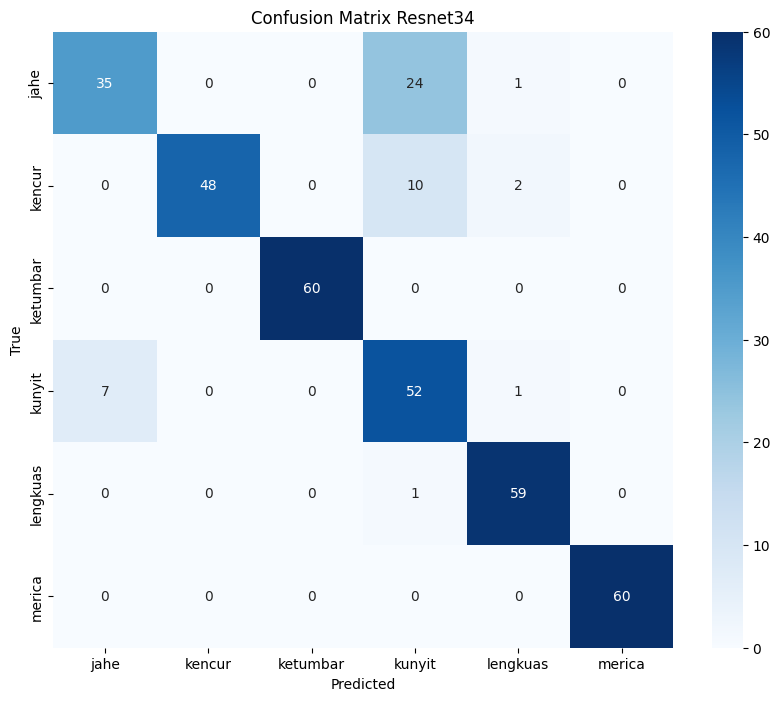

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('./finished model/resnet34.pth'))  # Replace 'your_model.pth' with the path to your saved model
model.eval()

# Define lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Define a function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Evaluate the model
evaluate_model(model, test_load)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(true_labels, predicted_labels) * 100
precision = precision_score(true_labels, predicted_labels, average='weighted') * 100
recall = recall_score(true_labels, predicted_labels, average='weighted') * 100

print(f'Akurasi: {accuracy:.2f}% || Presisi: {precision:.2f}% || Recall: {recall:.2f}%')

# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_remp, yticklabels=class_remp)  # Replace ... with your class labels
plt.title('Confusion Matrix Resnet34')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('Confusion Matrix Resnet34')
plt.show()

In [33]:
import torch.onnx
from torch.onnx import export

# Definisikan nama file untuk menyimpan model ONNX
onnx_path = 'resnet34.onnx'

# Mode evaluasi untuk memastikan bahwa dropout dan batch normalization bekerja dengan benar
model.eval()

input = torch.randn(1, 3, 224, 224)
export(model, input, "resnet34.onnx", verbose=True, input_names=["input_tensor"], output_names=["output"])

print(f'Model berhasil disimpan dalam format ONNX di: {onnx_path}')


Model berhasil disimpan dalam format ONNX di: resnet34.onnx


In [34]:
!onnx-tf convert -i resnet34.onnx -o resnet34.pb

2024-03-14 20:34:26.831290: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



C:\Users\nanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\nanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p

In [35]:
# Load model TensorFlow dari file .pb
model = tf.saved_model.load("resnet34.pb")

# Konversi model ke format TensorFlow Lite
convert = tf.lite.TFLiteConverter.from_saved_model("resnet34.pb")
tflite_model = convert.convert()

# Simpan model TFLite ke file
tflite_filename = "resnet34.tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)
print(f"Model tfLite berhasil disimpan ke: {tflite_filename}")

Model tfLite berhasil disimpan ke: resnet34.tflite


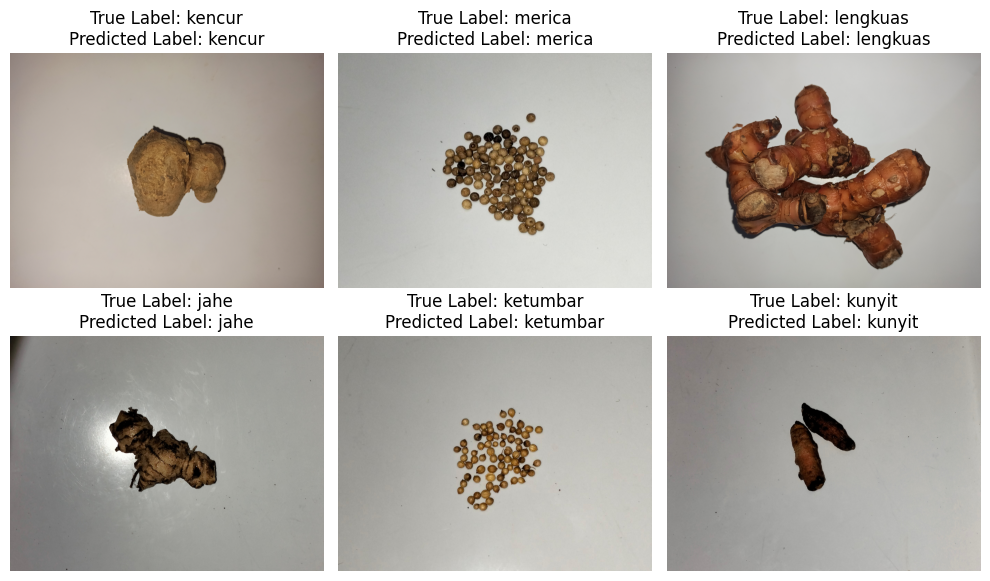

In [7]:
import os
import random
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image

# Definisikan transformasi yang sesuai
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tentukan path ke file .pth
model_path = './finished model/resnet34.pth'

# Definisikan model
num_classes = len(class_remp)  # Pastikan class_remp telah ditentukan sebelumnya
model = CNNResNet34(num_classes=num_classes)

# Muat parameter (weights) model dari file .pth
model.load_state_dict(torch.load(model_path))
model.eval()

# Tentukan path ke direktori yang berisi gambar-gambar dataset
data_dir = './dataset/dataset mentah/'

# Ambil 6 label yang berbeda secara acak
random_labels = random.sample(os.listdir(data_dir), 6)

# Buat dictionary untuk menyimpan satu gambar dari setiap label
one_image_per_label = {}

# Muat satu gambar untuk setiap label
for label in random_labels:
    label_dir = os.path.join(data_dir, label)
    image_name = random.choice(os.listdir(label_dir))
    image_path = os.path.join(label_dir, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = image_transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class = torch.argmax(probabilities).item()
    predicted_label = class_remp[predicted_class]
    one_image_per_label[label] = (image, predicted_label)

# Tampilkan gambar dan hasil prediksi
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for ax, (label, (image, predicted_label)) in zip(axes.flatten(), one_image_per_label.items()):
    ax.imshow(image)
    ax.set_title(f"True Label: {label}\nPredicted Label: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()
